In [1]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
os.chdir('/media/steven/WD_4TB/Dropbox/DSC/680/retail_forecasting/')
warnings.filterwarnings('ignore')

Reading in data and preparing, code repeated and condensed from EDA document.

In [2]:
features = pd.read_csv('Features data set.csv', index_col=[0,1])
sales = pd.read_csv('sales data-set.csv')
stores = pd.read_csv('stores data-set.csv', index_col=0)
sales_and_features = sales.join(features, lsuffix='_sales', rsuffix='_feature', on=['Store', 'Date'])
sales_and_features = sales_and_features[sales_and_features['Weekly_Sales'] > 0]
log_sales = np.log10(sales_and_features[sales_and_features.Weekly_Sales!=0].Weekly_Sales)
sales_and_features['log_sales'] = log_sales
sales_and_features.MarkDown1.fillna(0, inplace=True)
sales_and_features.MarkDown2.fillna(0, inplace=True)
sales_and_features.MarkDown3.fillna(0, inplace=True)
sales_and_features.MarkDown4.fillna(0, inplace=True)
sales_and_features.MarkDown5.fillna(0, inplace=True)
sales_features_and_stores = sales_and_features.join(stores, on='Store', rsuffix='_store')
sales_features_and_stores = pd.concat([sales_features_and_stores, pd.get_dummies(sales_features_and_stores['Type'])], axis=1)
sales_features_and_stores = pd.concat([sales_features_and_stores, pd.get_dummies(sales_features_and_stores['Store'], prefix='store')], axis=1)
sales_features_and_stores = pd.concat([sales_features_and_stores, pd.get_dummies(sales_features_and_stores['Dept'], prefix='dept')], axis=1)
y = sales_features_and_stores.log_sales
sales_features_and_stores.drop(['Date','Store','Dept','Weekly_Sales','IsHoliday_feature','log_sales','Type'], inplace=True, axis=1)
X = sales_features_and_stores
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [3]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [4]:
params = {
        'min_child_weight': list(range(20)),
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': list(np.arange(0.05,1.05,.05)),
        'max_depth': list(range(8,30))
        }

In [5]:
gbm = xgb.XGBRegressor(tree_method='hist', objective='reg:squarederror')

random_search = RandomizedSearchCV(estimator=gbm, param_distributions=params, n_iter=570, scoring='r2', cv=5, verbose=1, n_jobs=-1)

start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X, y)
timer(start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 10.8min finished



 Time taken: 0 hours 11 minutes and 21.73 seconds.


In [6]:
random_search.best_params_

{'subsample': 1.0,
 'min_child_weight': 14,
 'max_depth': 25,
 'gamma': 1,
 'colsample_bytree': 0.5}

In [8]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
report(random_search.cv_results_)            

Model with rank: 1
Mean validation score: 0.767 (std: 0.034)
Parameters: {'subsample': 1.0, 'min_child_weight': 14, 'max_depth': 25, 'gamma': 1, 'colsample_bytree': 0.5}

Model with rank: 2
Mean validation score: 0.765 (std: 0.028)
Parameters: {'subsample': 1.0, 'min_child_weight': 11, 'max_depth': 22, 'gamma': 5, 'colsample_bytree': 0.45}

Model with rank: 3
Mean validation score: 0.765 (std: 0.030)
Parameters: {'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 25, 'gamma': 2, 'colsample_bytree': 0.45}



In [20]:
random_search.cv_results_['param_min_child_weight']

masked_array(data=[0, 14, 8, 17, 13, 11, 15, 2, 14, 10, 7, 2, 7, 9, 0, 5,
                   3, 19, 15, 12, 13, 12, 8, 8, 1],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object)

Text(0, 0.5, 'Adjusted R^2')

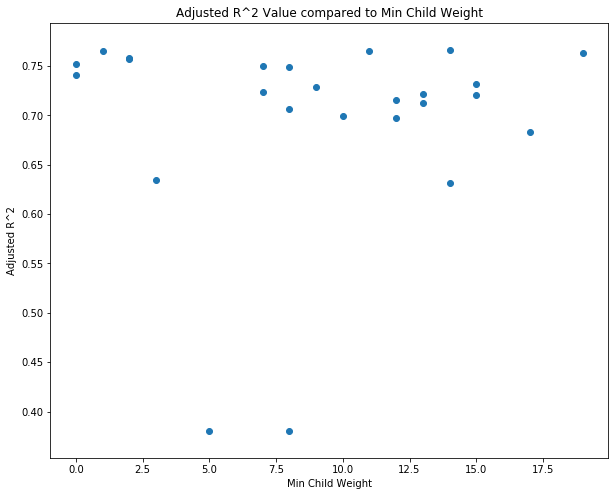

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.scatter(random_search.cv_results_['param_min_child_weight'],random_search.cv_results_['mean_test_score'])
plt.title('Adjusted R^2 Value compared to Min Child Weight')
plt.xlabel('Min Child Weight')
plt.ylabel('Adjusted R^2')

Text(0, 0.5, 'Adjusted R^2')

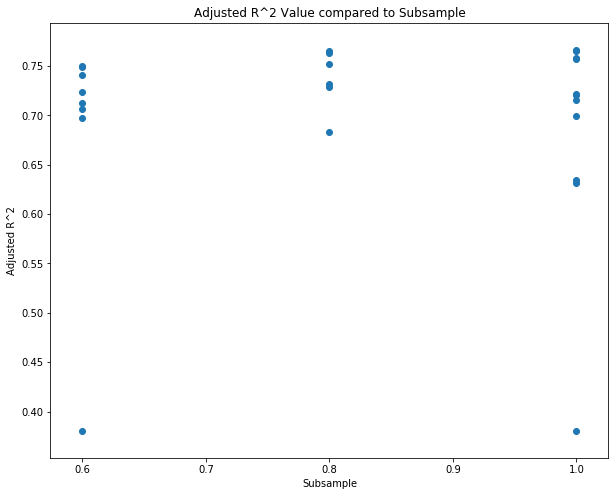

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.scatter(random_search.cv_results_['param_subsample'],random_search.cv_results_['mean_test_score'])
plt.title('Adjusted R^2 Value compared to Subsample')
plt.xlabel('Subsample')
plt.ylabel('Adjusted R^2')

Text(0, 0.5, 'Adjusted R^2')

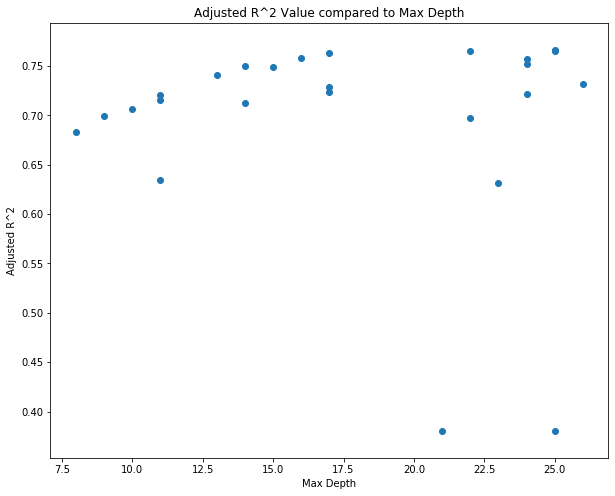

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.scatter(random_search.cv_results_['param_max_depth'],random_search.cv_results_['mean_test_score'])
plt.title('Adjusted R^2 Value compared to Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Adjusted R^2')

Text(0, 0.5, 'Adjusted R^2')

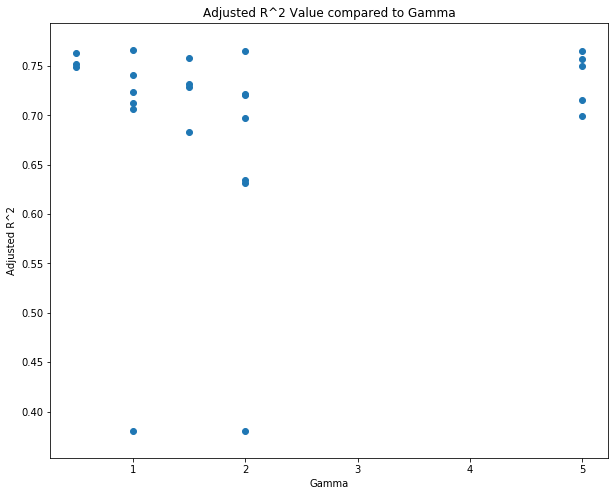

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.scatter(random_search.cv_results_['param_gamma'],random_search.cv_results_['mean_test_score'])
plt.title('Adjusted R^2 Value compared to Gamma')
plt.xlabel('Gamma')
plt.ylabel('Adjusted R^2')

Text(0, 0.5, 'Adjusted R^2')

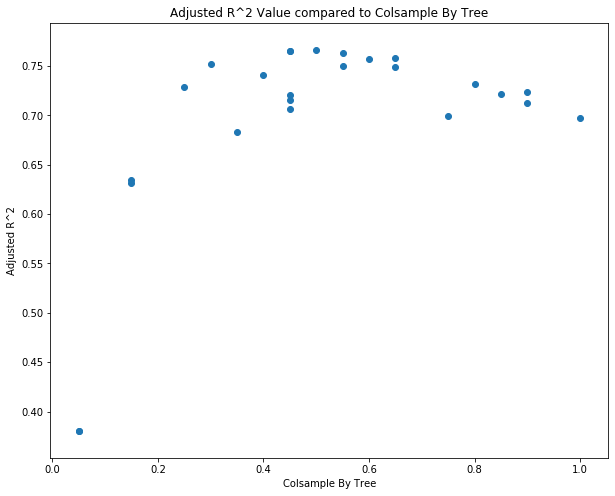

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.scatter(random_search.cv_results_['param_colsample_bytree'],random_search.cv_results_['mean_test_score'])
plt.title('Adjusted R^2 Value compared to Colsample By Tree')
plt.xlabel('Colsample By Tree')
plt.ylabel('Adjusted R^2')

In [36]:
import xgboost as xgb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials


class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def xgb_reg(self, para):
        reg = xgb.XGBRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}


In [50]:
from hyperopt import hp
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 40, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 30, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     100
}

xgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10,
    'verbose': True,
}

xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

obj = HPOpt(X_train, X_test, y_train, y_test)
xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

[17:26:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.16451	validation_1-rmse:3.16364

Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.


Will train until validation_1-rmse hasn't improved in 10 rounds.

[1]	validation_0-rmse:3.01495	validation_1-rmse:3.01415

[2]	validation_0-rmse:2.87206	validation_1-rmse:2.87125

[3]	validation_0-rmse:2.73684	validation_1-rmse:2.73607

[4]	validation_0-rmse:2.60931	validation_1-rmse:2.6086

[5]	validation_0-rmse:2.4885	validation_1-rmse:2.48777

[6]	validation_0-rmse:2.37342	validation_1-rmse:2.37275

[7]	validation_0-rmse:2.26446	validation_1-rmse:2.26386

[8]	validation_0-rmse:2.1622	validation_1-rmse:2.16167

[9]	validation_0-rmse:2.06469	validation_1-rmse:2.06424

[10]	validation_0-rmse:1.97271	validation_1-rmse:1.97233

[11]	validation_0-rmse:1.88613	validation_1-rmse:1.88585

[12]	validation_0-rmse:1.8028

In [52]:
xgb_opt

({'colsample_bytree': 3,
  'learning_rate': 3,
  'max_depth': 25,
  'min_child_weight': 4,
  'subsample': 0.9736063452295293},
 <hyperopt.base.Trials at 0x7f66edad38d0>)

In [61]:
params = {
    'learning_rate':0.15,
    'max_depth':30,
    'colsample_bytree':0.5,
    'min_child_weight':4,
    'subsample':0.9736063452295293
}
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=100,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
cv_results.iloc[-1]

train-rmse-mean    0.068174
train-rmse-std     0.001738
test-rmse-mean     0.178902
test-rmse-std      0.002026
Name: 99, dtype: float64

In [ ]:
y_mean = np.mean(y)
residuals = y-predicted

# Calculate total sum of squares
tss =  sum((y - y_mean)**2 )

# Calculate residual sum of squares
rss =  sum(residuals**2)

# Calculate R-squared
rsq  =  1 - (rss/tss)
print('The R-square of the test data is ', round(rsq,3))

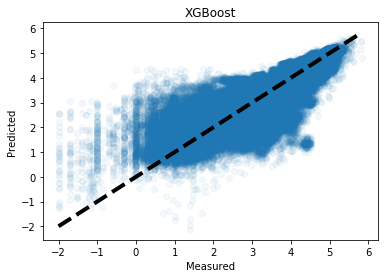

In [62]:
from sklearn.model_selection import cross_val_predict
xgb_reg = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.15, subsample=0.9736063452295293,
                           colsample_bytree=0.5, max_depth=30, min_child_weight=4, n_jobs=-1, verbose=3, objective="reg:squarederror")

xgb_reg.fit(X,y)
predicted = cross_val_predict(xgb_reg, X, y, cv=5, n_jobs=-1)
fig, ax = plt.subplots()
ax.scatter(y, predicted, alpha = 0.05)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
plt.title('XGBoost')
ax.set_ylabel('Predicted')
plt.show()